In [57]:
import torch
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import math


In [58]:
# phi_tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
phi_data = pd.read_json("phi-1.5/phi_entropies_tinystories_data.json")

# mpt_tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neox-20b') # MPT reused this tokenizer.
mpt_data = pd.read_json("mpt-7b/mpt_entropies_tinystories_data.json")

In [59]:
def process_data(data, num_layers, num_heads):
    n = 20 # we take the last 20 tokens of the data
    avg_entropies = torch.zeros((num_layers, num_heads, n))
    for storynum, story in enumerate(data):
        for layernum in range(num_layers):
            # for a certain story and a certain layer:
            last_n_entropy = torch.Tensor(data[story][f'layer {layernum}']['last_n_entropy'])
            # print(last_n_entropy[0].shape)
            avg_entropies[layernum] += last_n_entropy[0]

    avg_entropies /= (storynum+1)
    return avg_entropies

In [60]:
def max_entropy(seq_len):
    a = torch.Tensor([1/seq_len for _ in range(seq_len)])
    max_a = -torch.sum(a*torch.log(a))
    return max_a

def pretty_graph(avg_entropies, num_layers, model_name=""):
    blue, orange, green, red = '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'

    last_token_avg_entropies = avg_entropies[...,-1]
    fig2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
    for layernum,layer in enumerate(last_token_avg_entropies):
        # print(layer.shape)
        y2 = layer.tolist()
        axes2.scatter([layernum+1 for _ in range(len(y2))], y2, c=blue)
    x = [i for i in range(1,num_layers+1)]
    y = torch.mean(avg_entropies, dim=-2)[:,-1].tolist()   
    axes2.plot(x,y, c='k', linewidth=5)
    # axes2.plot(x,[max_entropy(100) for _ in range(len(x))], c='k', linestyle='--', label='al')
    axes2.set(title=f"{model_name}: Entropy of the last tokens attention vector", xlabel='layer number', ylabel='Entropy, averaged across 1000 sentences')
    plt.axhline(0, c='k')
    plt.axhline(max_entropy(200), c='k')
    plt.axhline(max_entropy(50), c='green', linestyle='--', label='75% sparse')
    plt.axhline(max_entropy(20), c='orange', linestyle='--', label='90% sparse')
    plt.axhline(max_entropy(2), c='red', linestyle='--', label='99% sparse')
    plt.legend()
    plt.show()

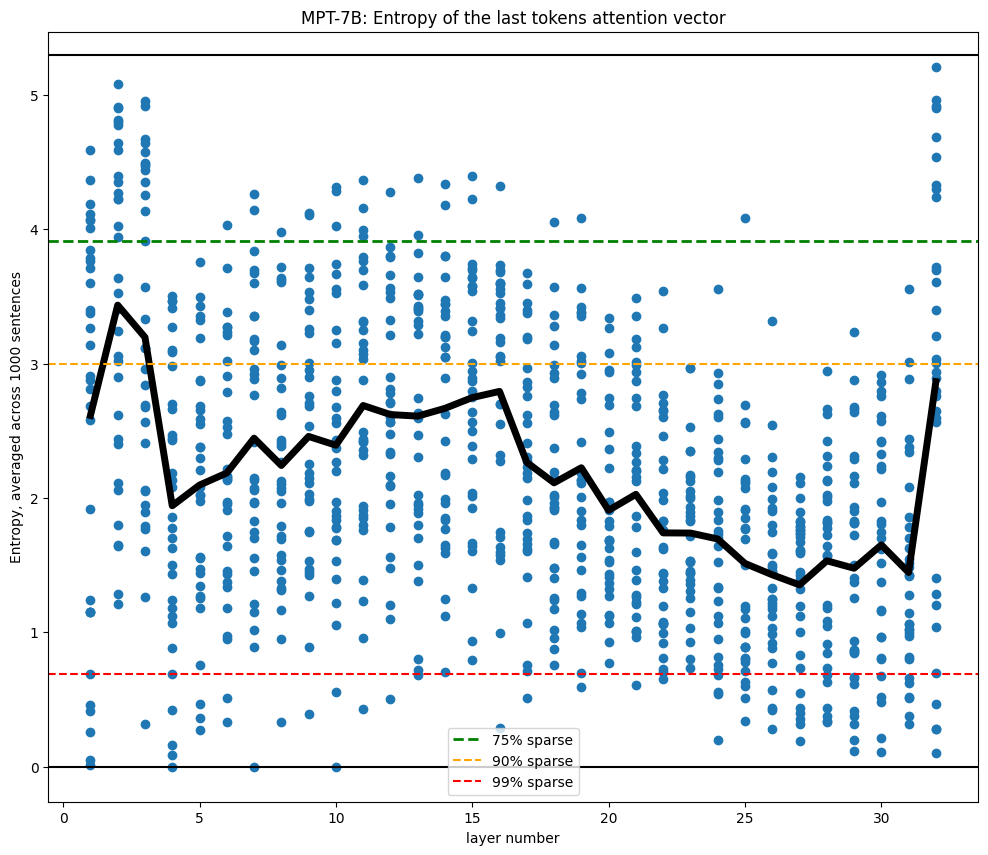

In [61]:
mpt_processed = process_data(mpt_data, num_layers=32, num_heads=32)
pretty_graph(mpt_processed, num_layers=32, model_name="MPT-7B")

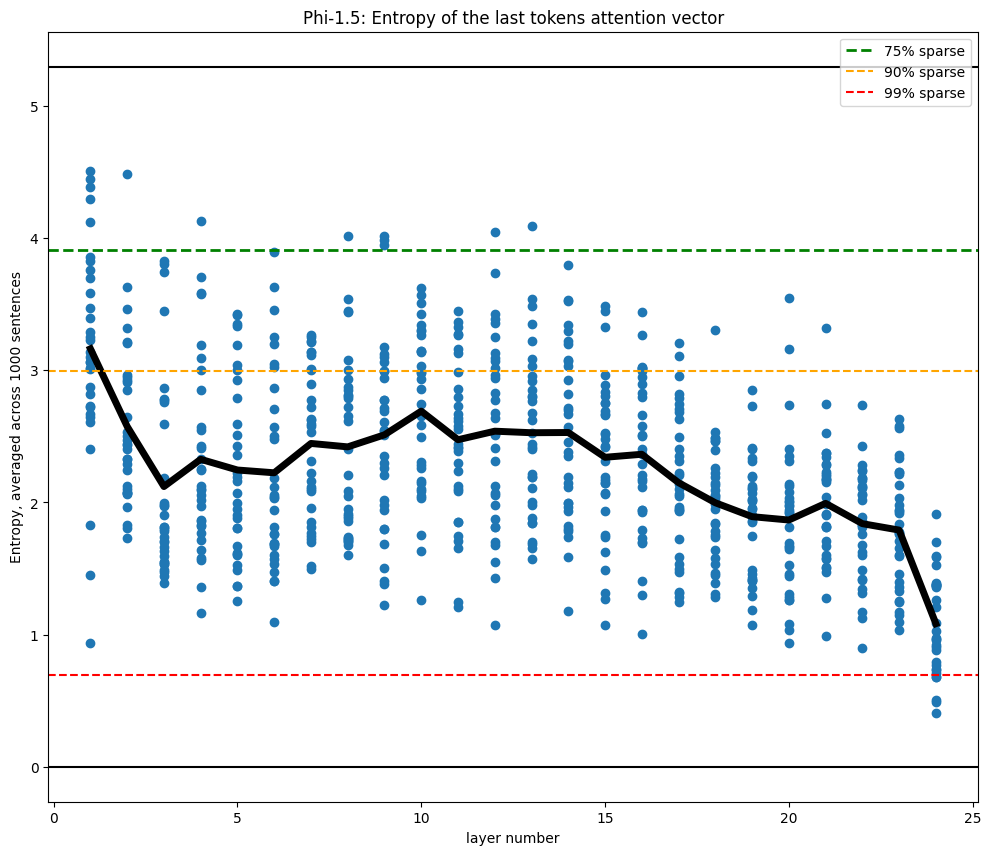

In [62]:
phi_processed = process_data(phi_data, num_layers=24, num_heads=32)
pretty_graph(phi_processed, num_layers=24, model_name="Phi-1.5")